In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
import json
import folium
from folium import plugins
from folium.plugins import MarkerCluster, Search

import shapely
from shapely.geometry import shape, Point

In [108]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [3]:
data = pd.read_csv('Food_data.csv')

## Inspecting data first

In [4]:
data.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2571281,AFC SUSHI @ JEWEL OSCO #3349,AFC SUSHI @ JEWEL OSCO #3349,2841387.0,Shared Kitchen User (Long Term),Risk 1 (High),16915 N HAAS AVE,TORRANCE,CA,90504.0,02/15/2023,Canvass,Pass,NaN,NaN,NaN,NaN
1,2569647,Sauganash Elementary School,Sauganash Elementary School,25211.0,School,Risk 1 (High),6040 N Kilpatrick (4700W) AVE,CHICAGO,IL,60646.0,01/13/2023,Canvass,Pass,NaN,NaN,NaN,NaN
2,2569445,JERSEY MIKES,JERSEY MIKE'S,2886344.0,Restaurant,Risk 1 (High),6153 N BROADWAY,CHICAGO,IL,60660.0,01/10/2023,License,Not Ready,NaN,41.993854,-87.660239,"(41.99385357489393, -87.66023863563797)"
3,2568003,HOT DOG EXPRESS,HOT DOG EXPRESS (T2 E5),1909525.0,Restaurant,Risk 2 (Medium),11601 W TOUHY AVE,CHICAGO,IL,60666.0,12/05/2022,Canvass,Pass,NaN,42.008536,-87.914428,"(42.008536400868735, -87.91442843927047)"
4,2567972,SBARRO,SBARRO,2882176.0,Restaurant,Risk 1 (High),500 W MADISON ST,CHICAGO,IL,60661.0,12/05/2022,License,Not Ready,NaN,41.881994,-87.639759,"(41.88199433820508, -87.6397586848809)"


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256789 entries, 0 to 256788
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Inspection ID    256789 non-null  int64  
 1   DBA Name         256789 non-null  object 
 2   AKA Name         254306 non-null  object 
 3   License #        256781 non-null  float64
 4   Facility Type    251715 non-null  object 
 5   Risk             256710 non-null  object 
 6   Address          256789 non-null  object 
 7   City             256602 non-null  object 
 8   State            256736 non-null  object 
 9   Zip              256704 non-null  float64
 10  Inspection Date  256789 non-null  object 
 11  Inspection Type  256788 non-null  object 
 12  Results          256789 non-null  object 
 13  Violations       186733 non-null  object 
 14  Latitude         255911 non-null  float64
 15  Longitude        255911 non-null  float64
 16  Location         255911 non-null  obje

## Finding useful features, analyzing data

In [6]:
city = data['City'].value_counts()

In [7]:
city = np.log1p(city)

<AxesSubplot: title={'center': 'Number of inspections for City'}>

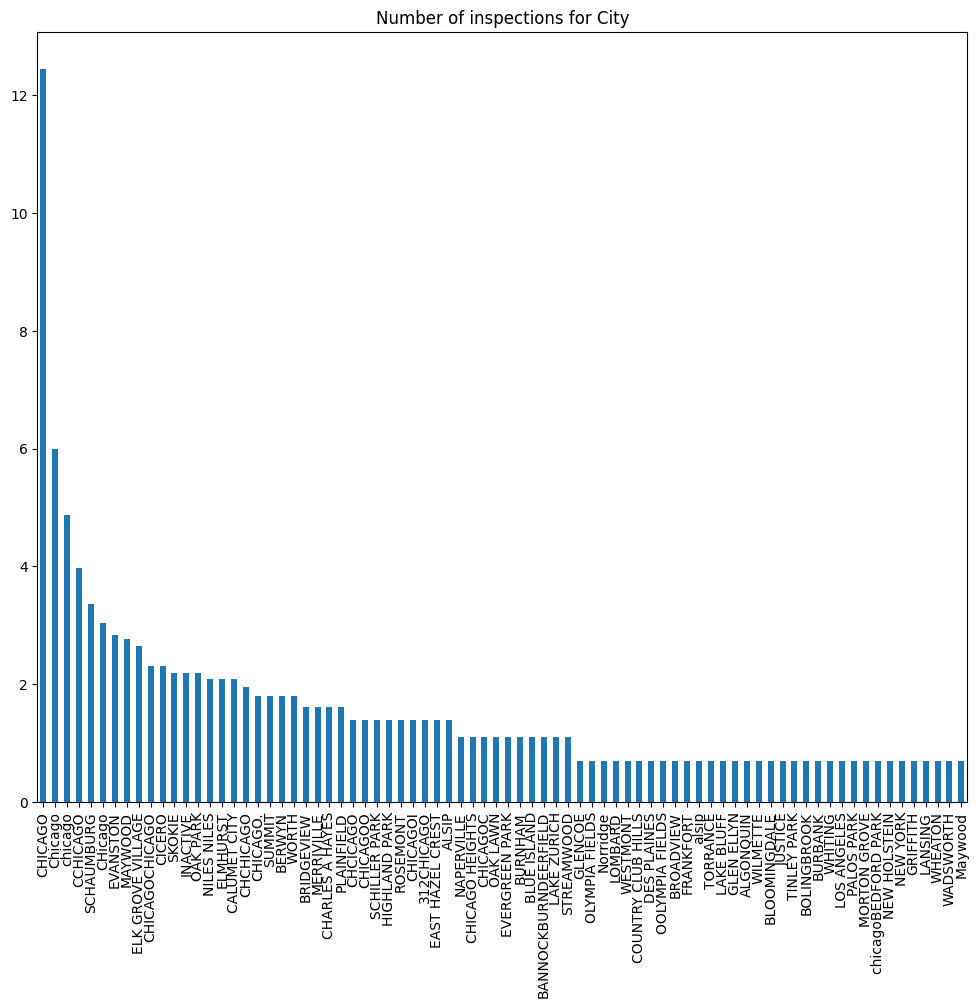

In [8]:
plt.figure(figsize=(12, 10))
city.plot(kind='bar', title = 'Number of inspections for City')

As we can see, there are a lot of misstypo's. We will get rid of them later. #TODO Chicago misstypo fix

In [9]:
Risk_info = data['Risk'].value_counts()

In [10]:
Risk_info = np.sqrt(Risk_info)

<AxesSubplot: title={'center': 'Risk Count'}>

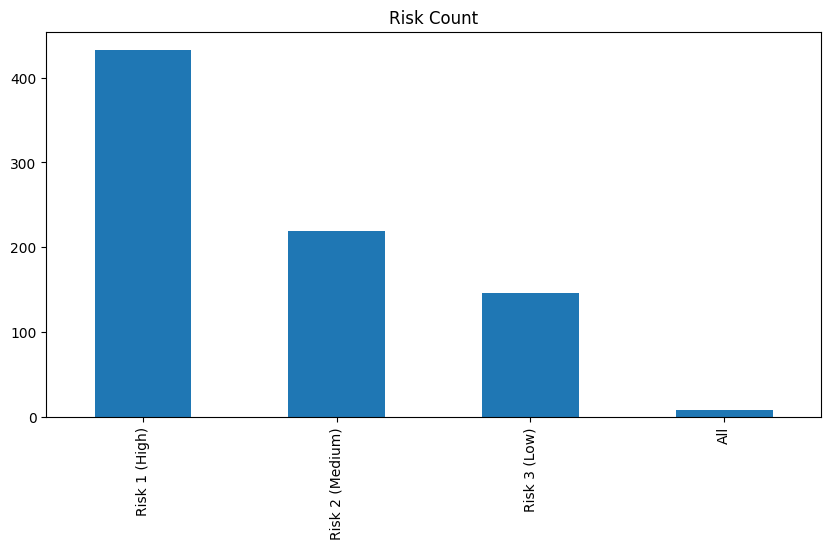

In [11]:
plt.figure(figsize=(10,5))
Risk_info.plot(kind='bar', title = 'Risk Count')

In [12]:
data['Inspection Date'] = pd.to_datetime(data['Inspection Date'])
inspection_counts = data.resample('M', on='Inspection Date').size()

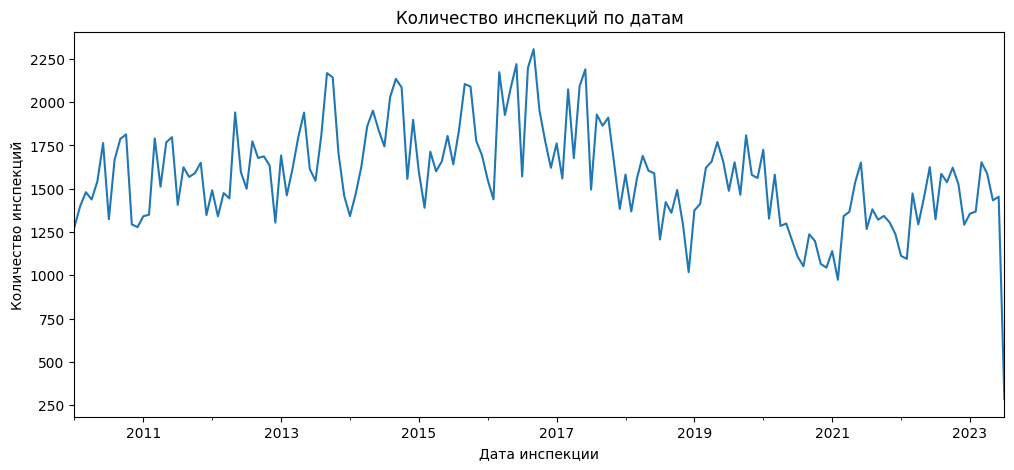

In [13]:
plt.figure(figsize=(12, 5))
inspection_counts.plot()
plt.title('Количество инспекций по датам')
plt.xlabel('Дата инспекции')
plt.ylabel('Количество инспекций')
plt.show()

As we can see, number of inspection on 2019-2021 is quite low. I can assume, that the main reason is COVID-2019.

In [14]:
Result_info = data['Results'].value_counts()

In [15]:
data['Results'].value_counts()

Pass                    132299
Fail                     49968
Pass w/ Conditions       39445
Out of Business          21815
No Entry                 10010
Not Ready                 3170
Business Not Located        82
Name: Results, dtype: int64

<AxesSubplot: title={'center': 'Results of inspections'}>

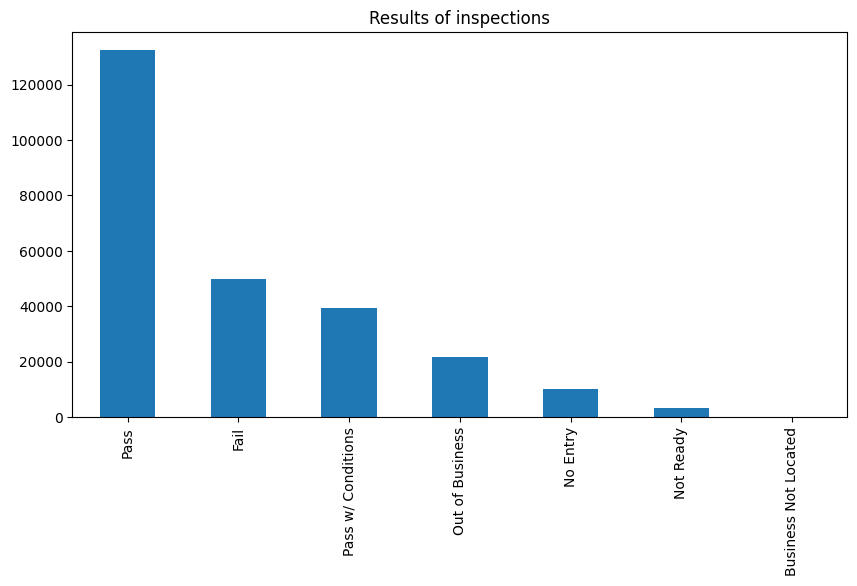

In [16]:
plt.figure(figsize=(10,5))
Result_info.plot(kind='bar', title = 'Results of inspections')

In [17]:
Zip_info = data['Zip'].value_counts()

In [18]:
Zip_info = Zip_info[Zip_info > 20]

<AxesSubplot: title={'center': 'ZipCode Inspection Count'}>

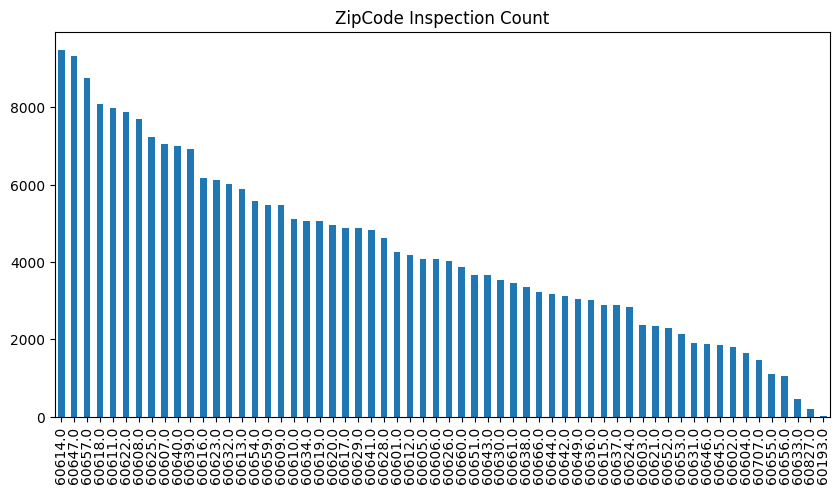

In [19]:
plt.figure(figsize=(10,5))
Zip_info.plot(kind='bar', title = 'ZipCode Inspection Count')

## Heatmap

In [20]:
corr = data.corr()

C:\Users\ncpaa\AppData\Local\Temp\ipykernel_11160\1351907255.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


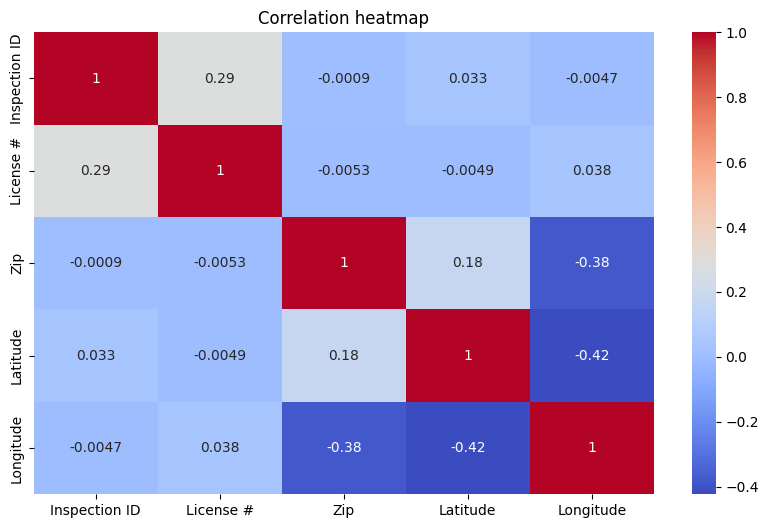

In [21]:
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation heatmap')
plt.show()

## Data preprocessing

We will now proceed with preparing the dataset for the analysis. Below we take the following preprocessing steps:
1. Making Licence # column a unique identifier in the dataset.
2. Fixing the zip codes by completing the missing values based on the values of Longitude and Latitude.
3. Fixing the City column by completing the missing values based on the zip code.
4. Standardizing the Inspection Type values by cleaning various namings and reducing the number of categories.ories.

In [22]:
print(f"Using DBA Name we can see there are {data['DBA Name'].nunique()} distinct names")

Using DBA Name we can see there are 31536 distinct names


In [23]:
print(f"Using restaurant Licenses we can see there are {data['License #'].nunique()} distinct names")

Using restaurant Licenses we can see there are 43524 distinct names


In [24]:
print(f"There are {data['License #'].isna().sum()} names that have NaN licence number")

There are 8 names that have NaN licence number


In [25]:
print(f"There are {len(data[data['License #'] == 0.0])} names that have zero licence number")

There are 670 names that have zero licence number


To be able to identify restaurants with license number equal to 0, we will assume that no two of such restaurants share the same location and the same name. Using this assumption, we can create artificial license numbers for restaurants with missing license numbers:

In [26]:
# Get the maximum license number that exists in the database and use it as starting point for the newly generated license numbers
start_id = int(data["License #"].max() + 1)
missing_licenses = data[(data["License #"] == 0)][["DBA Name","Location"]].copy().drop_duplicates()
missing_licenses["new License"] = [i for i in range(start_id, start_id+len(missing_licenses.drop_duplicates()))]

In [27]:
data = data.merge(missing_licenses, on=["DBA Name","Location"], how='left')

In [28]:
# Populate missing licence numbers with newly generated license numbers
data["License #"] = data["License #"].apply(lambda x: np.nan if x == 0 else x)
data["License #"] = data["License #"].fillna(value = data["new License"])
data.drop(columns=["new License"], inplace=True)

In [29]:
data.dropna(subset = 'License #', axis = 0, inplace = True)

In [30]:
data["License #"] = data["License #"].apply(lambda x : int(x))

In [31]:
print("There are {0} missing license numbers in our dataset".format(data[data["License #"] == 0].size))

There are 0 missing license numbers in our dataset


In [32]:
data = data[~((data['Longitude'].isna()) | (data['Latitude'].isna()))]

The big part of our analysis will be based on neighborhoods, therefore we will hugely rely on the Zip column.

In [33]:
print('There are {0} missing values for Zip column'.format(data[data['Zip'].isna()].shape[0]))
print('There are {0} missing values for City column'.format(data[data['City'].isna()].shape[0]))

There are 81 missing values for Zip column
There are 183 missing values for City column


We want to populate the missing Zip values based on the Latitude and Longitude. In order to do that, we must have those two features for all the restaurants in the dataset. That is why we decided to drop all entries where one of those features is missing.

In [34]:
zip_na = data[data['Zip'].isna()]

To populate Zip values based on coordinates, we use [shapely](https://pypi.org/project/Shapely/) - Python package for manipulation and analysis of planar geometric objects.

In [35]:
# Function that creates points from Latitude and Longitude
def create_points(df):
    coords = list(zip(df['Longitude'], df['Latitude']))
    res = []
    for coord in coords:
        res.append(shapely.geometry.Point(coord))
    return res

In [36]:
# Create list of points for which we want to get Zip code
points = create_points(zip_na)

In [37]:
# Method which checks whether the points are in area described in geojson file and returns data with zip value for found points
def populate_missing_zip(points, geojson_filename):
    # load GeoJSON file containing sectors
    state_geo_path = r'{0}'.format(geojson_filename)
    geo_json_data = json.load(open(state_geo_path))

    zip_found = []
    # check each polygon to see if it contains the point
    for feature in geo_json_data['features']:
        polygon = shapely.geometry.shape(feature['geometry'])
        for point in points: 
            if polygon.contains(point):
                point_complete = {'Longitude':point.x, 'Latitude':point.y, 'Zip':feature.get('properties', {}).get('zip')}
                zip_found.append(point_complete)
    return zip_found

In [38]:
# Find missing Zip values
zip_found = populate_missing_zip(points, 'chicago-zip.geojson')
print('Total {0} point found matching Chicago sectors.'.format(len(zip_found)))

Total 81 point found matching Chicago sectors.


In [39]:
zip_found = pd.DataFrame(zip_found)
zip_found.head()

,Longitude,Latitude,Zip
0,-87.774526,41.908949,60651
1,-87.716676,41.898995,60651
2,-87.721095,41.902606,60651
3,-87.721095,41.902606,60651
4,-87.624044,41.892716,60611


Now, we have to merge those results with the original dataset.

In [40]:
# Before merging, drop duplicate points
zip_found.drop_duplicates(inplace=True)

In [41]:
data = data.merge(zip_found,on=['Latitude','Longitude'], how='left',suffixes=('', '_notnull'))
data.Zip.fillna(value=data.Zip_notnull, inplace=True)
data.drop(columns=["Zip_notnull"], inplace=True)

In [42]:
print('There are {0} missing Zip left in the restaurant dataset.'.format(data[data.Zip.isnull()].shape[0]))

There are 0 missing Zip left in the restaurant dataset.


In [114]:
# Change type of Zip feature from float to string
data['Zip']=data['Zip'].apply(lambda x: str(int(x)))

### Completing City column based on zip codes

We will also fix the City column. Now we can use the Zip column to fill in the missing information about the city.

In [44]:
# Function that returns all Chicago Zips frem geojson file
def create_chicago_zip_list():
    state_geo_path = "chicago-zip.geojson"
    geo_json_data = json.load(open(state_geo_path))

    zips = []
   
    for feature in geo_json_data['features']:
        zips.append(str(feature.get('properties', {}).get('zip')))
    return set(zips)

In [45]:
# Get list of all Zip codes in Chicago
chicago_zip = create_chicago_zip_list()

In [46]:
# Check if there is any restaurant not in Chicago
not_in_chicago = len(data[data.City.isna() & (~data.Zip.isin(chicago_zip))])
print('There are {0} Zip values which are not in Chicago.'.format(not_in_chicago))

There are 0 Zip values which are not in Chicago.


In [47]:
# Replace all City missing values with Chicago
data.City.fillna(value='Chicago', inplace=True)

In [48]:
print('There are {0} missing City values left in the restaurant dataset.'.format(data[data.City.isnull()].shape[0]))

There are 0 missing City values left in the restaurant dataset.


In [49]:
data.City.unique()

array(['CHICAGO', 'Chicago', 'CHCHICAGO', 'chicago', 'CCHICAGO',
       'CHicago', 'CHICAGO.', 'CHICAGOCHICAGO', 'CHICAGOO', 'CHICAGOC',
       '312CHICAGO', 'chicagoBEDFORD PARK', 'CHCICAGO', 'CHARLES A HAYES',
       'LOMBARD', 'CHICAGOI', 'WESTMONT', 'SUMMIT', 'INACTIVE', 'alsip',
       'BLUE ISLAND'], dtype=object)

In [50]:
# Change all values for City column to be Chicago
data.City = 'Chicago'
data.City.unique()

array(['Chicago'], dtype=object)

### Standardizing/cleaning Inspection Type values

In [51]:
data['Inspection Type'].unique()

array(['License', 'Canvass', 'Non-Inspection', 'Canvass Re-Inspection',
       'Complaint', 'License Re-Inspection', 'Short Form Complaint',
       'Complaint Re-Inspection', 'Recent Inspection',
       'Suspected Food Poisoning',
       'Suspected Food Poisoning Re-inspection', 'Not Ready',
       'Consultation', 'Task Force Liquor 1475', 'Complaint-Fire',
       'Short Form Fire-Complaint', 'OUT OF BUSINESS', 'NO ENTRY',
       'License-Task Force', 'Tag Removal', 'Out of Business', 'No Entry',
       'out ofbusiness', 'Special Events (Festivals)', 'COVID COMPLAINT',
       'Recent inspection', 'fire complaint', 'FIRE', nan,
       'Complaint-Fire Re-inspection', 'KITCHEN CLOSED FOR RENOVATION',
       'CORRECTIVE ACTION', 'O.B.', 'LICENSE CANCELED BY OWNER',
       'OWNER SUSPENDED OPERATION/LICENSE', 'LICENSE CONSULTATION',
       'Illegal Operation', 'License consultation', 'Package Liquor 1474',
       'No entry', 'CANVASS SPECIAL EVENTS',
       'TWO PEOPLE ATE AND GOT SICK.', '

Looking at `Inspection Type` values we can see that they need some cleaning. According to the [document describing the dataset](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) we should have following inspection types:
 - **canvass**: regular inspections with frequency depending on establishment risk,
 - **complaint**: in a response to filed complaint,
 - **license**: when obtaining a license, as a requirement of launching the establishment (should be once for most or more if they failed, this might be a separate study case),
 - **suspect food poisoning**: specific type of *complaint* when someone reports getting ill after eating from there
 - **task-force**: for bars and taverns.

Also, as the linked document states, re-inspections can be done for most of the types and are indicated in the name of inspection type.

First, we replace NaN values in Inspection Type with "Unknown":

In [52]:
data.fillna(value={'Inspection Type': 'Unknown'}, inplace=True)

Now, since we may want to use the indication whether a particular inspection was a re-inspection or not, we add a separate column that will indicate that:

In [53]:
reinspection_pattern = 're-inspec|reinspec|re inspec'
data['Re-inspection'] = data['Inspection Type'].str.lower().str.contains(reinspection_pattern, regex=True)

In [54]:
inspection_types = data['Inspection Type'].unique().astype(str)
inspection_types_lower = np.char.lower(inspection_types)

In [55]:
# Replaces values in Inspection Type for records with keywords found in them with the specified replacement value
def standardize_by_finding_keyword(keywords, replacement):
  to_replace = np.array([])
  for keyword in keywords:
    to_replace = np.append(to_replace, inspection_types[np.char.find(inspection_types_lower, keyword) != -1])
  data['Inspection Type'] = data['Inspection Type'].replace(to_replace, value=replacement)

In [56]:
standardize_by_finding_keyword(['canvas'], 'Canvass')
standardize_by_finding_keyword(['complain'], 'Complaint')
standardize_by_finding_keyword(['license'], 'License')
standardize_by_finding_keyword(['task', 'liquor'], 'Task Force')

In [57]:
# Suspected Food Poisoning replacements
sfp_values = data['Inspection Type'].str.lower().str.contains('food|sfp', regex=True)
data.loc[sfp_values, 'Inspection Type'] = 'Suspected Food Poisoning'
standardize_by_finding_keyword(['sick'], 'Suspected Food Poisoning')

In [58]:
data.groupby(by='Inspection Type')['Inspection ID'].count()

Inspection Type
ADDENDUM                               1
Business Not Located                   1
CHANGED COURT DATE                     1
CITF                                   1
CORRECTIVE ACTION                      1
Canvass                           161253
Complaint                          42761
Consultation                         675
Duplicated                             1
FIRE                                   1
HACCP QUESTIONAIRE                     1
Illegal Operation                      5
KIDS CAFE                              1
KITCHEN CLOSED FOR RENOVATION          1
Kids Cafe'                             1
License                            45913
NO ENTRY                               8
No Entry                              60
No entry                               1
Non-Inspection                      2276
Not Ready                             20
O.B.                                   1
OUT OF BUSINESS                       23
Out of Business                      283


There are still a lot of values that appear only once in the entire dataset. There are also ones that could be merged into single categories (e.g. "no entry", "out of business", "recent inspection"). We also decide to leave the categories with significant amount of records, such as "Consultation". The ones we decide to drop will be reclassified under "Unknown" category.

In [59]:
# Replaces records with keyword found in category name to be classified in a given target category
def merge_categories(keyword, target_category):
  categories_containing_keyword = data['Inspection Type'].str.lower().str.contains(keyword)
  data.loc[categories_containing_keyword, 'Inspection Type'] = target_category  

In [60]:
merge_categories('recent inspection', 'Recent Inspection')
merge_categories('out of business', 'Out of Business')
merge_categories('no entry', 'No Entry')

In [61]:
known_list = ['License', 'Canvass', 'Complaint', 'Consultation', 'No Entry', 'Out of Business', 'Recent Inspection', 'Suspected Food Poisoning', 'Tag Removal', 'Task Force']
# Classify the rest as unknown
data.loc[~data['Inspection Type'].isin(known_list), 'Inspection Type'] = 'Unknown'

In [62]:
data.groupby(by='Inspection Type')['Inspection ID'].count()

Inspection Type
Canvass                     161253
Complaint                    42761
Consultation                   675
License                      45913
No Entry                        73
Out of Business                306
Recent Inspection              444
Suspected Food Poisoning      1173
Tag Removal                    601
Task Force                     316
Unknown                       2390
Name: Inspection ID, dtype: int64

Additionally, let's propagate "Out of Business" indication to "Results" column where it should be indicated:

In [63]:
out_of_business = data[data['Inspection Type'] == 'Out of Business'].index
data.loc[out_of_business, 'Results'] = 'Out of Business'

## Handling missing data

Text(0.5, 1.0, 'Counts of missing values')

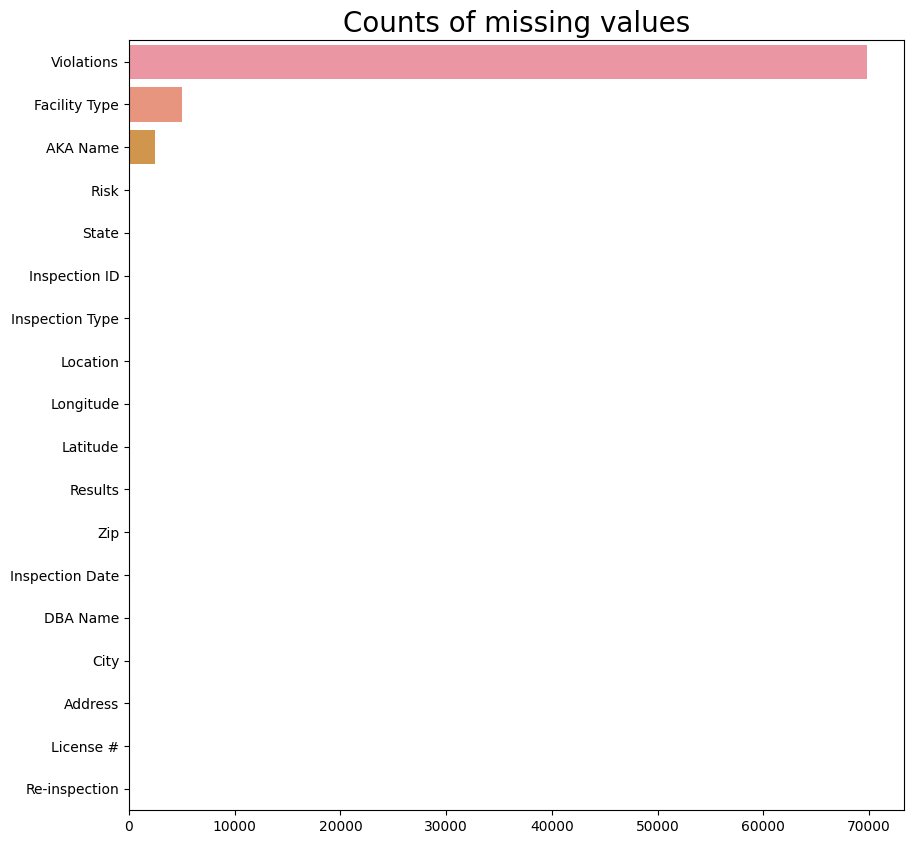

In [64]:
plt.figure(figsize=(10,10))
sns.barplot(x=data.isnull().sum().sort_values(ascending=False),y=data.isnull().sum().sort_values(ascending=False).index)
plt.title("Counts of missing values",size=20)

In [65]:
data.isna().sum()

Inspection ID          0
DBA Name               0
AKA Name            2469
License #              0
Facility Type       5059
Risk                  77
Address                0
City                   0
State                 53
Zip                    0
Inspection Date        0
Inspection Type        0
Results                0
Violations         69815
Latitude               0
Longitude              0
Location               0
Re-inspection          0
dtype: int64

In [66]:
data.shape

(255905, 18)

## Violations column

In [67]:
data['Violations'].describe()

count                                                186090
unique                                               184905
top       32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...
freq                                                     11
Name: Violations, dtype: object

Violations: An establishment can receive one or more of 45 distinct violations (violation 
numbers 1-44 and 70). For each violation number listed for a given establishment, the 
requirement the establishment must meet in order for it to NOT receive a violation is 
noted, followed by a specific description of the findings that caused the violation to be 
issed. 

From this information we can see, that NaN values are No violations. I will replace them now

In [68]:
data['Violations'] = data['Violations'].fillna('No Violations')

## AKA and DBA columns

Now let's analyze AKA column, because in my opinion, it doesn't look useful for our model

In [69]:
data['AKA Name'].describe()

count     253436
unique     29872
top       SUBWAY
freq        4246
Name: AKA Name, dtype: object

In [70]:
data['DBA Name'].describe()

count     255905
unique     31392
top       SUBWAY
freq        3449
Name: DBA Name, dtype: object

A lot of unique names. But there are a lot of missing information in AKA Name column so I would get rid of it. DBA Name is more stable and doesn't have any missing values. But to be sure, I will check on outliers

In [71]:
aka_name_counts = data['AKA Name'].value_counts()

outliers_aka_name = aka_name_counts[aka_name_counts <= 2]

dba_name_counts = data['DBA Name'].value_counts()

outliers_dba_name = dba_name_counts[dba_name_counts <= 2]

In [72]:
outliers_aka_name.count()

9299

In [73]:
outliers_dba_name.count()

9709

10000 values is a lot. Let's analyze if they have impact, but we have to change our results column.

In [74]:
result_mapping = {'Pass': 1, 'Fail': 0, 'Pass w/ Conditions': 1, 
                  'Out of Business': 0, 'No Entry': 0, 'Not Ready': 0, 'Business Not Located': 0}

# Replace the values in the Results column according to the mapping dictionary
data['Results'] = data['Results'].replace(result_mapping)

print(data['Results'].value_counts().sum())

255905


In [75]:
aka_name_outliers = data['AKA Name'].isin(outliers_aka_name.index)

print('Pass rate for common names:', data[~aka_name_outliers]['Results'].mean())
print('Pass rate for rare names:', data[aka_name_outliers]['Results'].mean())

dba_name_outliers = data['DBA Name'].isin(outliers_dba_name.index)

print('Pass rate for common DBA names:', data[~dba_name_outliers]['Results'].mean())
print('Pass rate for rare DBA names:', data[dba_name_outliers]['Results'].mean())

Pass rate for common names: 0.6808156042961195
Pass rate for rare names: 0.4256688639007367
Pass rate for common DBA names: 0.6817752324050884
Pass rate for rare DBA names: 0.42080011809861234


## Interesting

As we can see this columns are very important 

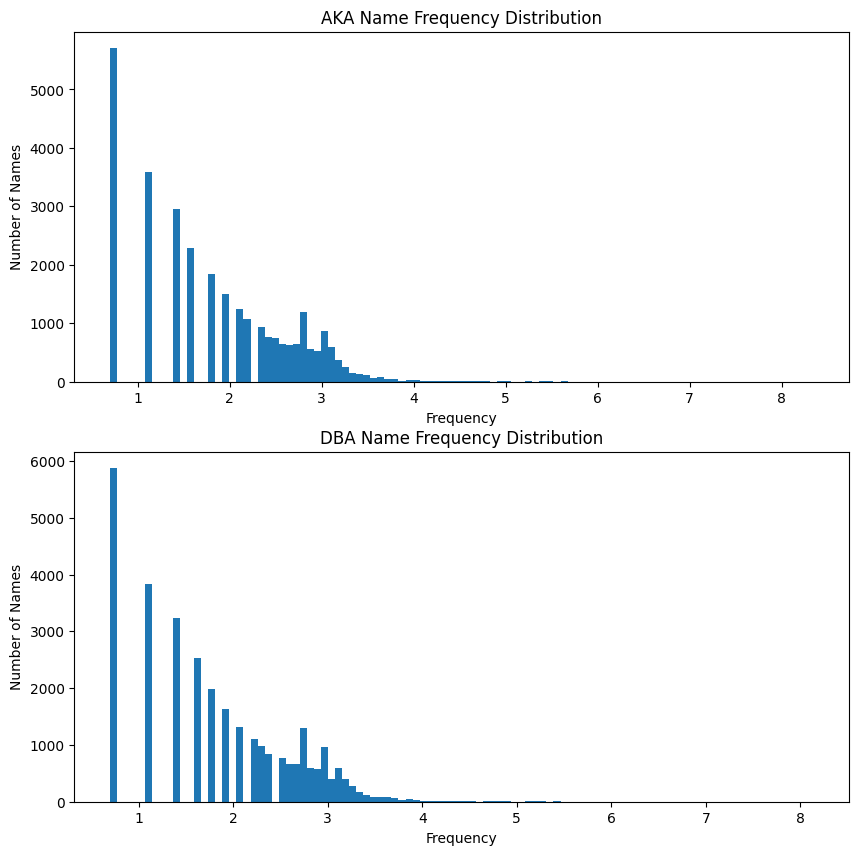

In [76]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))

AKA_counts = data['AKA Name'].value_counts()
AKA_counts = np.log1p(AKA_counts)

ax[0].hist(AKA_counts, bins=100)
ax[0].set_title('AKA Name Frequency Distribution')
ax[0].set_xlabel('Frequency')
ax[0].set_ylabel('Number of Names')

DBA_counts = data['DBA Name'].value_counts()
DBA_counts = np.log1p(DBA_counts)

ax[1].hist(DBA_counts, bins=100)
ax[1].set_title('DBA Name Frequency Distribution')
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('Number of Names')

plt.show()

In [77]:
from utils import pass_rates
# Test the function with different thresholds
for threshold in [2, 10, 20, 50, 100]:
    print(f'Threshold: {threshold}')
    print(pass_rates(data, threshold))
    print()

C:\Users\ncpaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Threshold: 2
{'AKA Name': {'Common': 0.6808156042961195, 'Rare': 0.4256688639007367}, 'DBA Name': {'Common': 0.6817752324050884, 'Rare': 0.42080011809861234}}

Threshold: 10
{'AKA Name': {'Common': 0.7125336196049913, 'Rare': 0.5745072177921905}, 'DBA Name': {'Common': 0.7185559816545497, 'Rare': 0.571809053199447}}

Threshold: 20
{'AKA Name': {'Common': 0.7058617304725845, 'Rare': 0.6489171211685346}, 'DBA Name': {'Common': 0.7181500095425918, 'Rare': 0.6457109018103886}}

Threshold: 50
{'AKA Name': {'Common': 0.7264758808846578, 'Rare': 0.6588545547321981}, 'DBA Name': {'Common': 0.762159352491275, 'Rare': 0.6568779452419738}}

Threshold: 100
{'AKA Name': {'Common': 0.7265278921165079, 'Rare': 0.6614741575374572}, 'DBA Name': {'Common': 0.7746704666904168, 'Rare': 0.660440971626726}}



We've chosen to use a threshold of 2 for determining "rare" names based on our analysis of pass rates for common and rare restaurant names. This means that any establishment name that appears two or fewer times in our dataset is considered "rare". 

Our observations showed that there is a significant difference between pass rates for commonly appearing names and those that are rarer. Specifically, the pass rate for common names was approximately 68%, while for rarer names, this dropped to around 44%. 

This pattern was consistent across both "AKA Name" and "DBA Name" categories, suggesting that it's not a fluke, but rather a genuine pattern in our data. 

We hypothesize that this pattern may arise due to a variety of factors. For example, it could be that less established or less known establishments, which might be more likely to have unique names, are less likely to pass inspections due to a lack of experience or resources. 

By incorporating this "rare name" information into our predictive model, we hope to capture some of this variation in pass rates and improve our model's accuracy.

Of course, this is just one approach, and there might be other, possibly more effective ways to handle this aspect of the data. We will continually evaluate the performance of our model and adjust our strategy as necessary.

Okay, but what about AKA and DBA. The results looks similar for both. Let's go deeper.

In [78]:
matching_names = (data['AKA Name'] == data['DBA Name']).mean()
print('The names match in {:.1%} of cases.'.format(matching_names))

The names match in 73.2% of cases.


In [79]:
# Assuming df is your DataFrame and 'AKA Name' is the column with missing values
missing_akas = data['AKA Name'].isna()

# Analyzing distribution of missing 'AKA Name' across different categories
print('Facility Type')
print(data[missing_akas]['Facility Type'].value_counts())
print('Risks')
print(data[missing_akas]['Risk'].value_counts())
print('Results')
print(data[missing_akas]['Results'].value_counts())

Facility Type
Restaurant                                    1126
Grocery Store                                  707
Mobile Food Dispenser                           69
Liquor                                          49
School                                          48
Wholesale                                       42
Bakery                                          37
Daycare (2 - 6 Years)                           27
Children's Services Facility                    22
Daycare Above and Under 2 Years                 12
COMMISSARY FOR SOFT SERVE ICE CREAM TRUCKS      12
Daycare Combo 1586                              12
TAVERN                                          11
Catering                                         9
Golden Diner                                     7
GROCERY STORE/DELI                               5
Special Event                                    5
EXERCISE AND NUTRITION BAR                       5
ROOFTOP                                          4
RETAIL STORE     

Facility Type: The 'Facility Type' column contains a variety of categories, including 'Restaurant', 'Grocery Store', 'School', 'Liquor', and others. Since the 'AKA Name' is the name the public would know the establishment as, and considering that 'Restaurant' is the most common facility type, the 'DBA Name' is likely to be recognizable to the public in most cases. Thus, the 'AKA Name' might not provide substantial additional information for predicting the 'Results'.

Risks: The 'Risks' column indicates the risk level of the establishment, with Risk 1 (High), Risk 2 (Medium), and Risk 3 (Low). The distribution of risks is relatively balanced, indicating that the risk level alone might not be a strong predictor for the 'Results'. Therefore, the 'AKA Name' may not provide significant predictive value in this context.

Results: The 'Results' column shows that there is a somewhat balanced distribution between passing (0) and failing (1) inspections. This balance suggests that other features, such as violations or inspection type, might play a more influential role in predicting the 'Results' rather than the specific naming (AKA or DBA).

Given these considerations, dropping the 'AKA Name' column is likely to have minimal impact on the prediction of the 'Results'.

In [80]:
data.drop('AKA Name', axis = 1, inplace = True)

Let's check if there is any missing values left in our dataset

In [81]:
data.isna().sum()

Inspection ID         0
DBA Name              0
License #             0
Facility Type      5059
Risk                 77
Address               0
City                  0
State                53
Zip                   0
Inspection Date       0
Inspection Type       0
Results               0
Violations            0
Latitude              0
Longitude             0
Location              0
Re-inspection         0
dtype: int64

Same DBA's have everything same, so we can group them

In [82]:
for column in ['Facility Type', 'License #', 'Risk']:
    data.loc[:, column] = data.groupby('License #')[column].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan))

Also same Facility type have same risk. I think this is good logic :)

In [83]:
data['Facility Type'] = data.groupby('Risk')['Facility Type'].apply(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan))

C:\Users\ncpaa\AppData\Local\Temp\ipykernel_11160\1085365725.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data['Facility Type'] = data.groupby('Risk')['Facility Type'].apply(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan))


License number is unique, and we can't fill it. So we replace it with placeholder. We can even delete it

There are some missing data left and their amount is same. I can assume it's the same rows. So I will fill them with Address

In [84]:
data['Facility Type'].fillna('Unknown', inplace=True)
data['Risk'].fillna('Unknown', inplace=True)

state_fill_value = data['State'].mode().iloc[0] 
data['State'].fillna(state_fill_value, inplace=True)

I would also drop Inspection ID because it has low correlation

In [85]:
data.drop('Inspection ID', axis = 1, inplace = True)

In [86]:
data['Re-inspection'] = data['Re-inspection'].map(lambda x: int(x))

In [87]:
data.head()

,DBA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,Re-inspection
0,JERSEY MIKES,2886344,Restaurant,Risk 1 (High),6153 N BROADWAY,Chicago,IL,60660,2023-01-10,License,0,No Violations,41.993854,-87.660239,"(41.99385357489393, -87.66023863563797)",0
1,HOT DOG EXPRESS,1909525,Restaurant,Risk 2 (Medium),11601 W TOUHY AVE,Chicago,IL,60666,2022-12-05,Canvass,1,No Violations,42.008536,-87.914428,"(42.008536400868735, -87.91442843927047)",0
2,SBARRO,2882176,Restaurant,Risk 1 (High),500 W MADISON ST,Chicago,IL,60661,2022-12-05,License,0,No Violations,41.881994,-87.639759,"(41.88199433820508, -87.6397586848809)",0
3,EL POLLO REAL,2232132,Restaurant,Risk 1 (High),3835 W 31ST ST,Chicago,IL,60623,2022-11-30,Canvass,1,No Violations,41.836834,-87.720832,"(41.836833676558776, -87.72083154727216)",0
4,KOTO,2872350,Restaurant,Risk 1 (High),258 W 31ST ST,Chicago,IL,60616,2022-10-07,License,1,No Violations,41.838316,-87.634045,"(41.83831568602238, -87.6340451596087)",0


In [88]:
data['DBA Name'].value_counts() 

SUBWAY                        3449
DUNKIN DONUTS                 1802
MCDONALD'S                     719
7-ELEVEN                       524
CHIPOTLE MEXICAN GRILL         406
                              ... 
WALGREENS #1031                  1
SMILIN' JIM'S SALOON             1
EL RANCHITO                      1
JEWEL FOOD STORE #3089           1
GREAT AMERICAN BAGEL, INC.       1
Name: DBA Name, Length: 31392, dtype: int64

In [115]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255905 entries, 0 to 255904
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   DBA Name         255905 non-null  object
 1   Facility Type    255905 non-null  int64 
 2   Risk             255905 non-null  int64 
 3   Zip              255905 non-null  object
 4   Inspection Type  255905 non-null  int64 
 5   Results          255905 non-null  int64 
 6   Re-inspection    255905 non-null  int64 
 7   Violation Codes  255905 non-null  int32 
 8   nb_violation     255905 non-null  int64 
dtypes: int32(1), int64(6), object(2)
memory usage: 26.6+ MB


In [90]:
data['Risk'].value_counts()

Risk 1 (High)      186526
Risk 2 (Medium)     48057
Risk 3 (Low)        21204
Unknown                62
All                    56
Name: Risk, dtype: int64

In [91]:
risk_mapping = {"Risk 1 (High)": "3", 'Risk 2 (Medium)': "2", "Risk 3 (Low)": "1", "All": "1", "Unknown" : "1"}
data['Risk'] = data['Risk'].map(risk_mapping)

In [92]:
data['Risk'].value_counts()

3    186526
2     48057
1     21322
Name: Risk, dtype: int64

In [93]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255905 entries, 0 to 255904
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   DBA Name         255905 non-null  object        
 1   License #        255905 non-null  int64         
 2   Facility Type    255905 non-null  object        
 3   Risk             255905 non-null  object        
 4   Address          255905 non-null  object        
 5   City             255905 non-null  object        
 6   State            255905 non-null  object        
 7   Zip              255905 non-null  object        
 8   Inspection Date  255905 non-null  datetime64[ns]
 9   Inspection Type  255905 non-null  object        
 10  Results          255905 non-null  int64         
 11  Violations       255905 non-null  object        
 12  Latitude         255905 non-null  float64       
 13  Longitude        255905 non-null  float64       
 14  Location         255

In [94]:
data.fillna(value={'Violations': ''}, inplace=True)

In [95]:
data.Violations

0                                             No Violations
1                                             No Violations
2                                             No Violations
3                                             No Violations
4                                             No Violations
                                ...                        
255900    18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...
255901    18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...
255902    33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...
255903                                        No Violations
255904                                        No Violations
Name: Violations, Length: 255905, dtype: object

In [96]:
import pandas as pd

# Make sure that "Violations" is a string
data['Violations'] = data['Violations'].astype(str)

# Define function to extract violation codes
def extract_violation_codes(violation):
    if 'No Violations' in violation:
        return [0]  # return list with 0 as violation code
    else:
        # Splitting at '.' and taking the first part (the violation code)
        return [int(v.split('.')[0].strip()) for v in violation.split('|') if v.strip()]

# Apply function to "Violations" column to create "Violation Codes"
data['Violation Codes'] = data['Violations'].apply(extract_violation_codes)

# Create "nb_violation" column as count of violation codes
# Adjusting it to be 0 when "Violation Codes" contains a 0
data['nb_violation'] = data['Violation Codes'].apply(lambda x: 0 if 0 in x else len(x))

# Check the DataFrame
print(data.head())

          DBA Name  License # Facility Type Risk             Address     City  \
0     JERSEY MIKES    2886344    Restaurant    3    6153 N BROADWAY   Chicago   
1  HOT DOG EXPRESS    1909525    Restaurant    2  11601 W TOUHY AVE   Chicago   
2           SBARRO    2882176    Restaurant    3   500 W MADISON ST   Chicago   
3    EL POLLO REAL    2232132    Restaurant    3     3835 W 31ST ST   Chicago   
4             KOTO    2872350    Restaurant    3      258 W 31ST ST   Chicago   

  State    Zip Inspection Date Inspection Type  Results     Violations  \
0    IL  60660      2023-01-10         License        0  No Violations   
1    IL  60666      2022-12-05         Canvass        1  No Violations   
2    IL  60661      2022-12-05         License        0  No Violations   
3    IL  60623      2022-11-30         Canvass        1  No Violations   
4    IL  60616      2022-10-07         License        1  No Violations   

    Latitude  Longitude                                  Location  \

In [97]:
missing_values = data.isnull().sum()
print(missing_values)


DBA Name           0
License #          0
Facility Type      0
Risk               0
Address            0
City               0
State              0
Zip                0
Inspection Date    0
Inspection Type    0
Results            0
Violations         0
Latitude           0
Longitude          0
Location           0
Re-inspection      0
Violation Codes    0
nb_violation       0
dtype: int64


In [98]:
target_distribution = data['Results'].value_counts()
print(target_distribution)


1    170934
0     84971
Name: Results, dtype: int64


In [99]:
correlations = data.corr()
print(correlations)

               License #   Results  Latitude  Longitude  Re-inspection  \
License #       1.000000 -0.043758 -0.004788   0.036553       0.010217   
Results        -0.043758  1.000000  0.005131  -0.000602       0.234658   
Latitude       -0.004788  0.005131  1.000000  -0.423938      -0.021263   
Longitude       0.036553 -0.000602 -0.423938   1.000000       0.013125   
Re-inspection   0.010217  0.234658 -0.021263   0.013125       1.000000   
nb_violation   -0.047462 -0.077218 -0.008335  -0.010284      -0.111713   

               nb_violation  
License #         -0.047462  
Results           -0.077218  
Latitude          -0.008335  
Longitude         -0.010284  
Re-inspection     -0.111713  
nb_violation       1.000000  


C:\Users\ncpaa\AppData\Local\Temp\ipykernel_11160\1449212874.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = data.corr()


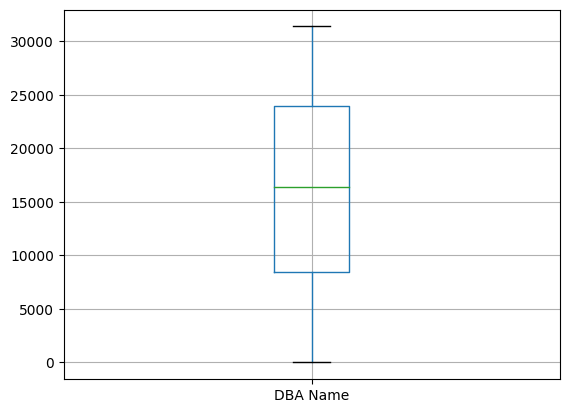

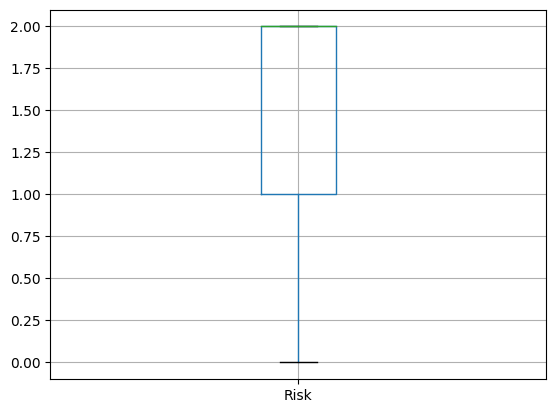

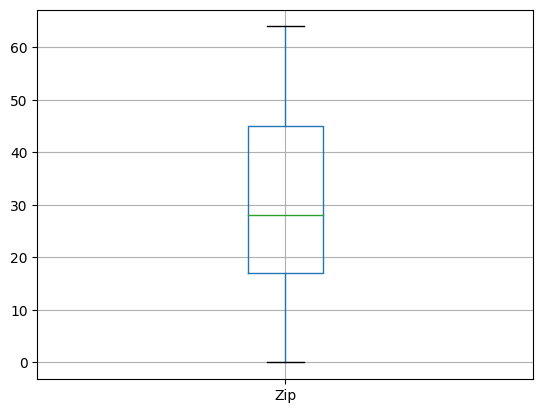

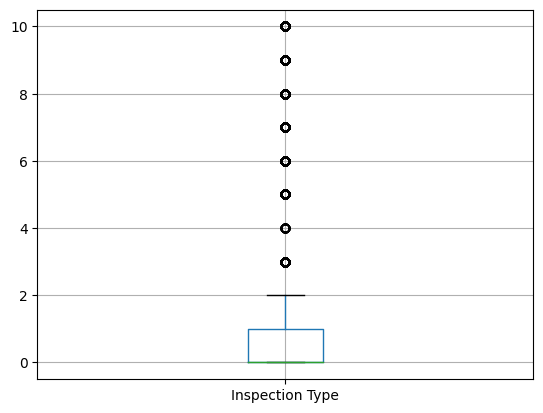

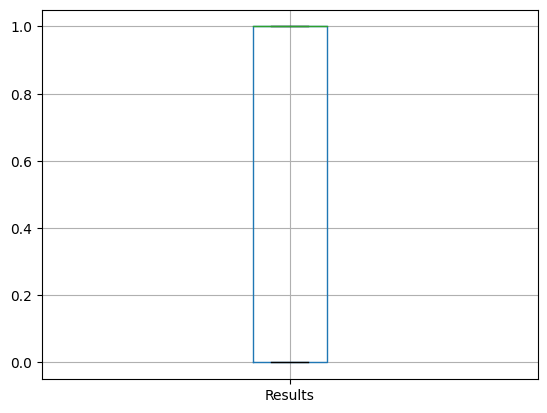

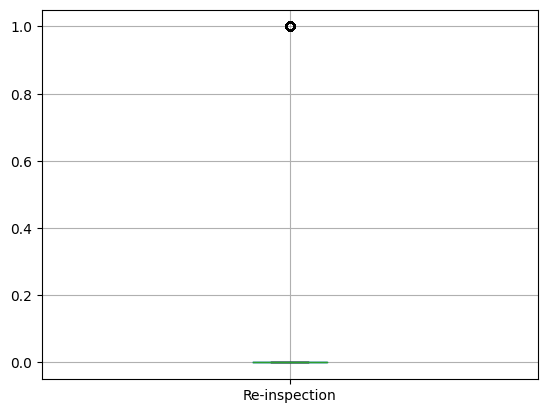

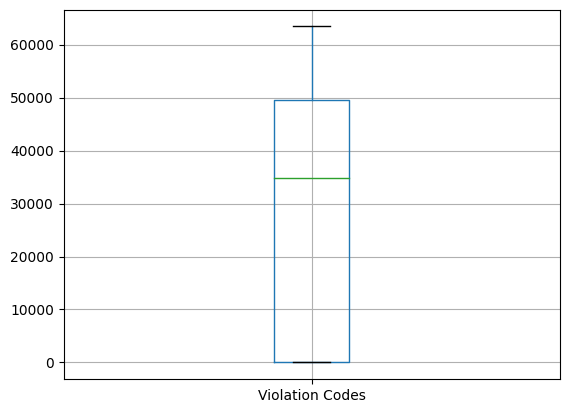

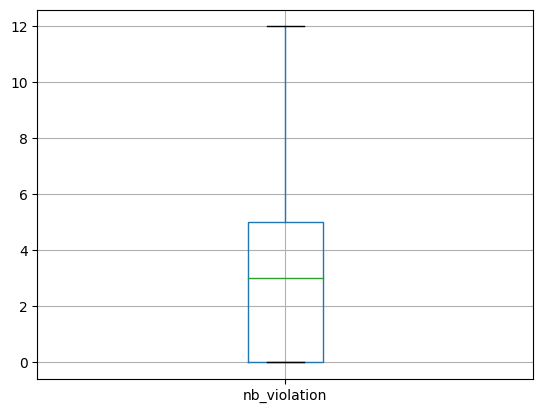

In [164]:
numerical_columns = data.select_dtypes(include=['int', 'float']).columns
for column in numerical_columns:
    data.boxplot(column=column)
    plt.show()

In [163]:
data['Facility Type'].value_counts()

388      169947
215       35005
407       15776
111        5192
Other      4112
45         3609
144        3373
141        3067
272        1806
109        1569
270        1093
301         849
300         846
242         744
213         713
145         691
450         546
417         386
143         311
415         275
410         261
409         217
164         188
32          171
412         125
305         122
67          121
253         104
Name: Facility Type, dtype: int64

In [162]:
threshold = 100  # This is just an example threshold
value_counts = data['Facility Type'].value_counts()
to_remove = value_counts[value_counts <= threshold].index
data['Facility Type'].replace(to_remove, 'Other', inplace=True)

In [101]:
print(data['DBA Name'].value_counts())

SUBWAY                        3449
DUNKIN DONUTS                 1802
MCDONALD'S                     719
7-ELEVEN                       524
CHIPOTLE MEXICAN GRILL         406
                              ... 
WALGREENS #1031                  1
SMILIN' JIM'S SALOON             1
EL RANCHITO                      1
JEWEL FOOD STORE #3089           1
GREAT AMERICAN BAGEL, INC.       1
Name: DBA Name, Length: 31392, dtype: int64


In [166]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 251219 entries, 0 to 255904
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   DBA Name         251219 non-null  int64 
 1   Facility Type    251219 non-null  object
 2   Risk             251219 non-null  int64 
 3   Zip              251219 non-null  int64 
 4   Inspection Type  251219 non-null  int64 
 5   Results          251219 non-null  int64 
 6   Re-inspection    251219 non-null  int64 
 7   Violation Codes  251219 non-null  int32 
 8   nb_violation     251219 non-null  int64 
dtypes: int32(1), int64(7), object(1)
memory usage: 18.2+ MB


In [142]:
data.Risk.value_counts()

2    186526
1     48057
0     21322
Name: Risk, dtype: int64

In [112]:
data.drop('Violations', axis = 1, inplace = True)

In [106]:
# Convert list of violation codes to string
data['Violation Codes'] = data['Violation Codes'].apply(lambda x: ' '.join(map(str, x)))

le = LabelEncoder()

# Apply LabelEncoder
data['Violation Codes'] = le.fit_transform(data['Violation Codes'])

In [168]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

categorical_features = ["DBA Name", "Facility Type", "Risk", "Zip", "Inspection Type"]
numerical_features = ["Re-inspection", "Violation Codes", "nb_violation"]

# combine categorical and numerical features
features = categorical_features + numerical_features

# apply label encoding for categorical features
data[categorical_features] = data[categorical_features].astype(str).apply(lambda col: le.fit_transform(col))

# Handle imbalance in target variable
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(data[features], data['Results'])  # use combined features here

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Target encoding
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Models
models = [
    LogisticRegression(max_iter=1000),
    RandomForestClassifier(),
    SGDClassifier(),  
    XGBClassifier(use_label_encoder=False, eval_metric='logloss')  # Add parameters to avoid warning
]

# Train and evaluate models
for model in models:
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(classification_report(y_test, predictions))

C:\Users\ncpaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


              precision    recall  f1-score   support

           0       0.73      0.84      0.78     33897
           1       0.81      0.68      0.74     33940

    accuracy                           0.76     67837
   macro avg       0.77      0.76      0.76     67837
weighted avg       0.77      0.76      0.76     67837

              precision    recall  f1-score   support

           0       0.89      0.95      0.92     33897
           1       0.95      0.89      0.92     33940

    accuracy                           0.92     67837
   macro avg       0.92      0.92      0.92     67837
weighted avg       0.92      0.92      0.92     67837

              precision    recall  f1-score   support

           0       0.72      0.83      0.77     33897
           1       0.80      0.68      0.74     33940

    accuracy                           0.76     67837
   macro avg       0.76      0.76      0.76     67837
weighted avg       0.76      0.76      0.76     67837

              preci

Best parameters for Random Forest:  {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best parameters for Logistic Regression:  {'C': 0.1, 'penalty': 'l2'}


C:\Users\ncpaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Best parameters for SGD:  {'alpha': 0.01, 'loss': 'log', 'penalty': 'l2'}


C:\Users\ncpaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\ncpaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\ncpaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Best parameters for XGBoost:  {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
Feature: 0, Score: 0.10736
Feature: 1, Score: 0.03404
Feature: 2, Score: 0.01336
Feature: 3, Score: 0.10317
Feature: 4, Score: 0.05202
Feature: 5, Score: 0.08850
Feature: 6, Score: 0.47165
Feature: 7, Score: 0.12990


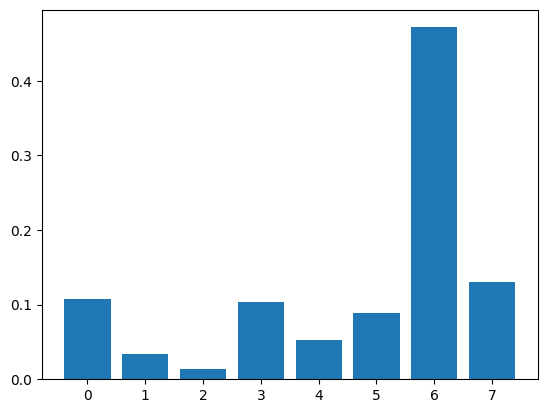

In [118]:
# Hyperparameters grid for RandomForest
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20],
    'min_samples_split': [2, 5]
}

rf_grid = GridSearchCV(RandomForestClassifier(), rf_params, cv=3, n_jobs=-1)
rf_grid.fit(X_train, y_train)

print("Best parameters for Random Forest: ", rf_grid.best_params_)

# Hyperparameters grid for Logistic Regression
lr_params = {
    'C': [0.1, 1, 10],
    'penalty': ['l2']
}

lr_grid = GridSearchCV(LogisticRegression(max_iter=1000), lr_params, cv=3, n_jobs=-1)
lr_grid.fit(X_train, y_train)

print("Best parameters for Logistic Regression: ", lr_grid.best_params_)

# Hyperparameters grid for SGD
sgd_params = {
    'alpha': [0.0001, 0.01, 1],
    'loss': ['hinge', 'log'],
    'penalty': ['l2']
}

sgd_grid = GridSearchCV(SGDClassifier(), sgd_params, cv=3, n_jobs=-1)
sgd_grid.fit(X_train, y_train)

print("Best parameters for SGD: ", sgd_grid.best_params_)

# Hyperparameters grid for XGB
xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6]
}

xgb_grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgb_params, cv=3, n_jobs=-1)
xgb_grid.fit(X_train, y_train)

print("Best parameters for XGBoost: ", xgb_grid.best_params_)

# Train the model with the best parameters
rf_best = RandomForestClassifier(n_estimators=rf_grid.best_params_['n_estimators'],
                                 max_depth=rf_grid.best_params_['max_depth'],
                                 min_samples_split=rf_grid.best_params_['min_samples_split'])

rf_best.fit(X_train, y_train)

# Get importance
importance = rf_best.feature_importances_

# Summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

# Plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [169]:
rf_best = RandomForestClassifier(n_estimators=200,
                                 max_depth=None,
                                 min_samples_split=2)

rf_best.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [170]:
training_accuracy = rf_best.score(X_train, y_train)
test_accuracy = rf_best.score(X_test, y_test)

print("Training Accuracy: ", training_accuracy)
print("Test Accuracy: ", test_accuracy)

Training Accuracy:  0.9896847187160257
Test Accuracy:  0.919159160929876


In [136]:
from sklearn.metrics import classification_report

rf_predictions = rf_best.predict(X_test)
print(classification_report(y_test, rf_predictions))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92     34204
           1       0.95      0.89      0.92     34170

    accuracy                           0.92     68374
   macro avg       0.92      0.92      0.92     68374
weighted avg       0.92      0.92      0.92     68374



In [119]:
# Print accuracy for RandomForest
print("Best accuracy for Random Forest: ", rf_grid.best_score_)

# Print accuracy for Logistic Regression
print("Best accuracy for Logistic Regression: ", lr_grid.best_score_)

# Print accuracy for SGD
print("Best accuracy for SGD: ", sgd_grid.best_score_)

# Print accuracy for XGBoost
print("Best accuracy for XGBoost: ", xgb_grid.best_score_)

Best accuracy for Random Forest:  0.899657763893375
Best accuracy for Logistic Regression:  0.7607186958399555
Best accuracy for SGD:  0.7257233952254483
Best accuracy for XGBoost:  0.8808529625174927
